<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import itertools
import os
from tqdm import tqdm
import numpy as np
import re
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '/tmp/working/machinlearning/6/ident/data/capstone_user' 

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [4]:
def get_list(user_data,\
             session_length=10, window_size=10):
#         from IPython.core.debugger import Tracer; Tracer()() 
        N=user_data.shape[0]
        r_b = lambda x: x+session_length
        slice_list=[(i,r_b(i) if r_b(i)<N else N) for i in range(0,N,window_size)]
        return slice_list

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path,feature_names, 
                                    session_length=10, window_size=10):
    
    ''' ВАШ КОД ЗДЕСЬ'''
    pat = re.compile("user([\d]+)[.]")
    list_sites=[]
    list_users = []
    
    sites = ["site{}".format(i) for i in range(1,11)]
    times = ['time{0}'.format(i) for i in range(1,11)]
    names_=zip(times,sites)
    names=list(itertools.chain(*names_))
    
    unique = lambda x: len(set(x))-1 if 0 in x else len(set(x))
        
    with open(site_freq_path,"rb") as f:
        site_freq = pickle.load(f)

    for u_id,f in tqdm(enumerate(sorted(glob(path_to_csv_files+'/*')))):
#     f=path_to_csv_files+'/user0001.csv'
        user_data = pd.read_csv(f)
        
        user_data.site=user_data.site.apply(lambda x: site_freq[x][0])
        slice_list = get_list(user_data,session_length,window_size)
        
        list_users += [int(re.search(pat,f).group(1))] * len(slice_list)
        list_sites += [user_data.values[ind[0]:ind[1]].reshape(-1) for ind in slice_list]
        
    
    df = pd.DataFrame(list_sites,columns = names)
    df[times]=df[times].apply(pd.to_datetime)
    df[sites]=df[sites].fillna(0).astype(int)
    
    time_df = pd.DataFrame(index=df.index)
    time_df['max'] = df[times].max(axis=1)
    time_df['min'] = df[times].min(axis=1)
    time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')
     
    df['#unique_sites']=[unique(i) for i in df[sites].values]
    
    df['start_hour'] = time_df['min'].apply(lambda x: x.hour)
    df['day_of_week'] = time_df['min'].apply(lambda x: x.dayofweek)
    df['session_timespan']=time_df['seconds']
#     from IPython.core.debugger import Tracer; Tracer()()
    df['user_id'] = list_users
    
    list_feat = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
    df = df[list_feat]
    df.columns = feature_names

    return df

In [172]:
%lprun -f hunc hunc(50000,5)

In [5]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

3it [00:00, 20.75it/s]


In [6]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,3,2,2,7,2,1,10,6,11,9,7998.0,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60.0,2,12,4,1
2,3,2,5,5,2,0,0,0,0,0,7935.0,3,9,4,2
3,4,1,2,1,2,1,1,6,8,4,7998.0,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,1471.0,3,12,4,3


**Проверим функцию на игрушечном примере.**

In [15]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

3it [00:00, 44.25it/s]


In [16]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,3,2,2,7,2,1,10,6,11,9,7998.0,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60.0,2,12,4,1
2,3,2,5,5,2,0,0,0,0,0,7935.0,3,9,4,2
3,4,1,2,1,2,1,1,6,8,4,7998.0,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,1471.0,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [5]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_10users  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

10it [00:08,  1.31it/s]


CPU times: user 8.29 s, sys: 304 ms, total: 8.59 s
Wall time: 9.09 s


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [11]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_150usersa  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

150it [01:22,  3.66it/s]


CPU times: user 1min 22s, sys: 996 ms, total: 1min 23s
Wall time: 1min 26s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [7]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week']]
new_features_150users = train_data_150usersa[['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']]

NameError: name 'train_data_150usersa' is not defined

In [14]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [6]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['user_id'].map(id_name_dict)

In [7]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

In [186]:
del download_plotlyjs, plot, iplot
del plotly
del go
del init_notebook_mode

In [8]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [9]:
x=train_data_10users['session_timespan']
x_less_2= x[x<200]

In [10]:
trace0 = go.Histogram(
    x=x_less_2,
    name='длинна сессии',
    nbinsx=25,
    marker=dict(                    
            color="darkviolet"
        )
)

data = [trace0]
layout = {'title': 'длинна сессии'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

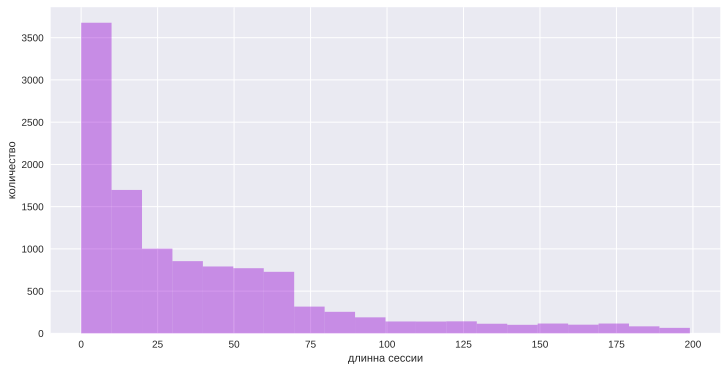

In [11]:
%config InlineBackend.figure_format = 'svg' 
plt.figure(figsize=(12,6))
hist_sess=sns.distplot(x_less_2,bins=20,kde=False,color='darkviolet')
hist_sess.set(xlabel='длинна сессии',ylabel='количество')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

In [12]:
unique_sites_data=train_data_10users['#unique_sites']

In [13]:
value_count=unique_sites_data.value_counts()

In [14]:
%config InlineBackend.figure_format = 'png' 
trace0 = go.Bar(
    x=value_count.index,
    y=value_count.values,
    name='количесвто уникальных сайтов',
    marker=dict(                    
            color="aqua"
        )
)

data = [trace0]
layout = {'title': 'количесвто уникальных сайтов'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

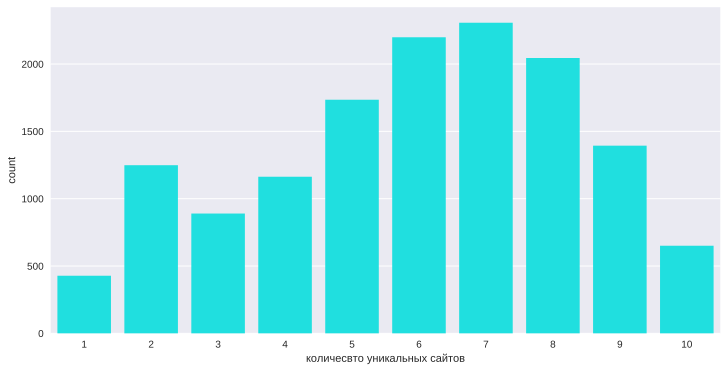

In [15]:
%config InlineBackend.figure_format = 'svg' 
plt.figure(figsize=(12,6))
hist_sess=sns.countplot(unique_sites_data,color='aqua')
hist_sess.set(xlabel='количесвто уникальных сайтов')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

In [16]:
d={key:val['#unique_sites'] for (key,val) in train_data_10users[['#unique_sites','target']].groupby(['target'])}

In [107]:
?hist_sess.set_title()

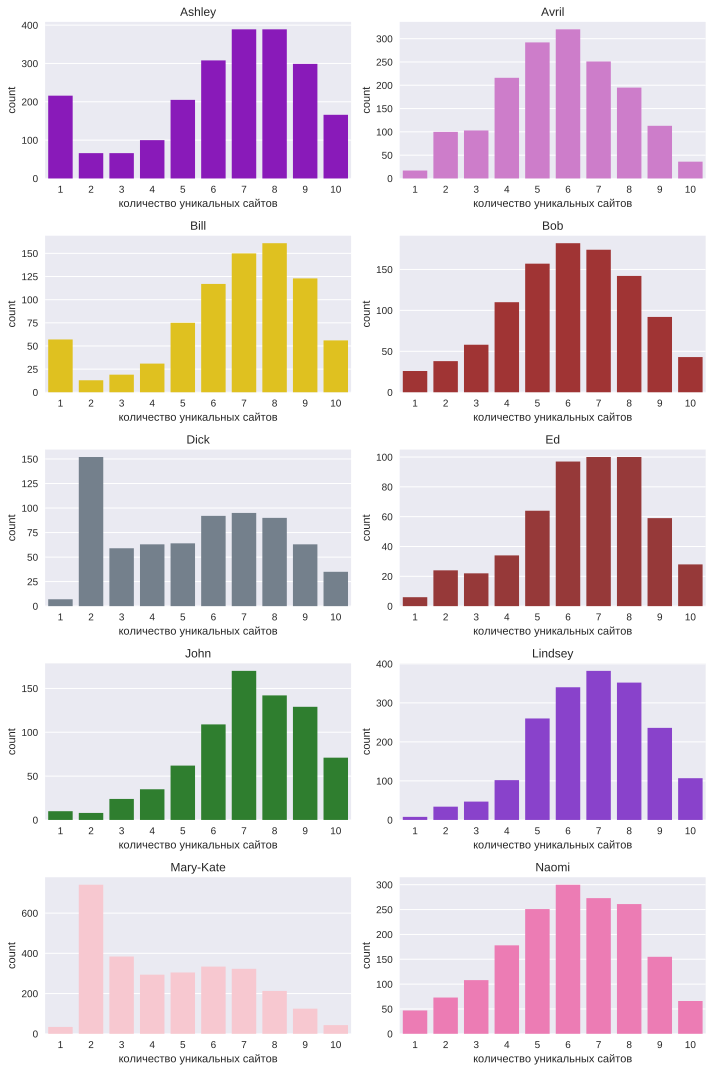

In [17]:
%config InlineBackend.figure_format = 'svg' 
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,15))
for numb,(name,val) in enumerate(d.items()):
    hist_sess=sns.countplot(val,color=color_dic[name], ax=axes[numb // 2, numb % 2])
    hist_sess.set_title(name)
    hist_sess.set(xlabel='количество уникальных сайтов')
fig.tight_layout()
plt.show()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

In [18]:
data=train_data_10users['start_hour']

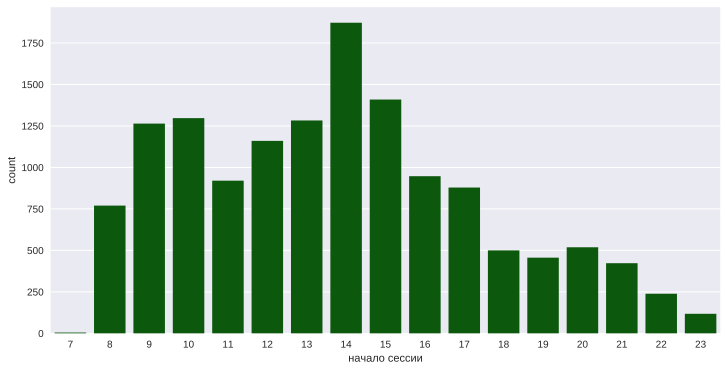

In [19]:
%config InlineBackend.figure_format = 'svg' 
plt.figure(figsize=(12,6))
hist_sess=sns.countplot(data,color='darkgreen')
hist_sess.set(xlabel='начало сессии')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

In [20]:
d={key:val['start_hour'] for (key,val) in train_data_10users[['start_hour','target']].groupby(['target'])}

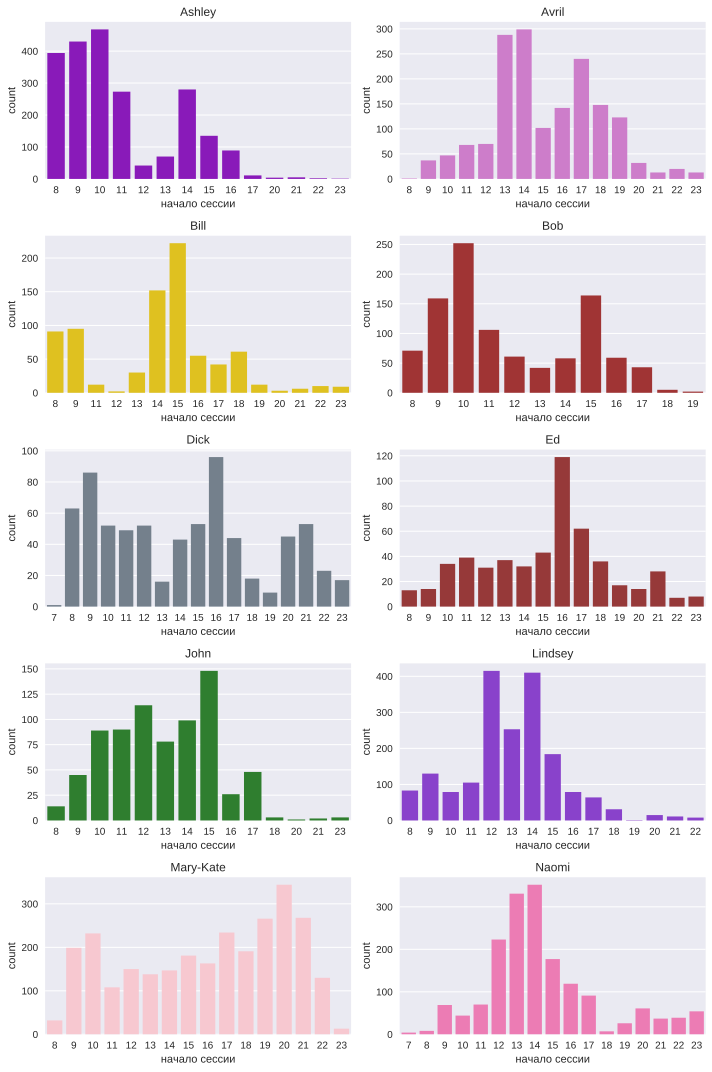

In [21]:
%config InlineBackend.figure_format = 'svg' 
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,15))
for numb,(name,val) in enumerate(d.items()):
    hist_sess=sns.countplot(val,color=color_dic[name], ax=axes[numb // 2, numb % 2])
    hist_sess.set_title(name)
    hist_sess.set(xlabel='начало сессии')
fig.tight_layout()
plt.show()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

In [22]:
data=train_data_10users['day_of_week']

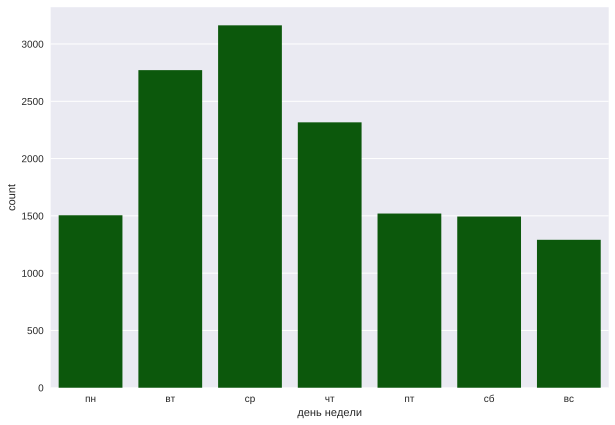

In [23]:
%config InlineBackend.figure_format = 'svg' 
plt.figure(figsize=(10,7))
day_of_week = ['пн','вт','ср','чт','пт','сб','вс']

hist_sess=sns.countplot(data,color='darkgreen')
hist_sess.set(xlabel='день недели')

plt.xticks(range(7),day_of_week)
plt.show()

In [24]:
type(hist_sess)

matplotlib.axes._subplots.AxesSubplot

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

In [25]:
d={key:val['day_of_week'] for (key,val) in train_data_10users[['day_of_week','target']].groupby(['target'])}

In [26]:

hist_sess.set(xlabel='день недели')

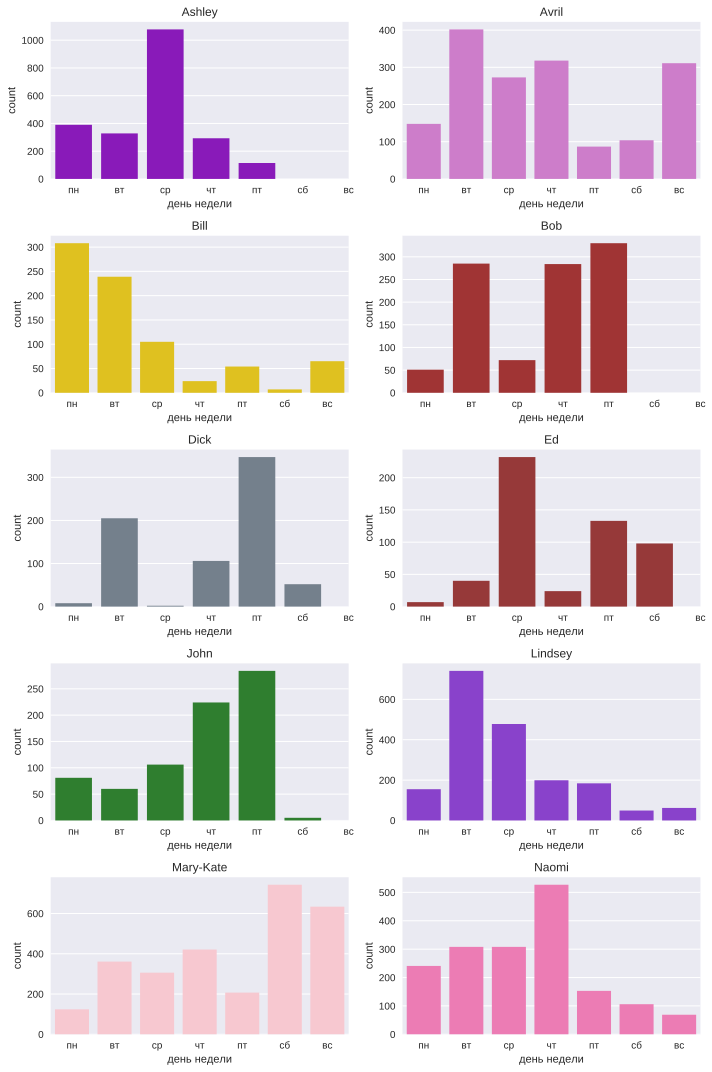

In [27]:
%config InlineBackend.figure_format = 'svg' 

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,15))
for numb,(name,val) in enumerate(d.items()):
    hist_sess=sns.countplot(val,color=color_dic[name], ax=axes[numb // 2, numb % 2])
    hist_sess.set_title(name)
    hist_sess.set(xlabel='день недели')
    plt.sca(axes[numb // 2, numb % 2])
    plt.xticks(range(7),day_of_week)

    fig.tight_layout()
plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [42]:
with open(PATH_TO_DATA+'/site_freq_10users.pkl','rb') as f:
    site_freq_10 = pickle.load(f)

In [64]:
df_freq = pd.DataFrame(data=list(site_freq_10.values()),index=list(site_freq_10.keys()),\
                                                        columns = ['index','count'])

In [82]:
df_freq=df_freq.sort_values(by='count',ascending=False,kind='mergesort')

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [91]:
top10_freqs = df_freq.head(10)['count'].values
top10_sites = df_freq.head(10)['count'].index

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

In [ ]:
sns.barplot ''' ВАШ КОД ЗДЕСЬ '''

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 